<a href="https://colab.research.google.com/github/asimenia-akrivou/asimenia/blob/main/AkrivouAsimeniaThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


uploaded = files.upload()
filenames = list(uploaded.keys())
chess_img = cv2.imread(filenames[0])  # chess image
carpet_img = cv2.imread(filenames[1])  # carpet image

# In case the pixels are "almost black"
threshold = 50

# Resize carpet image
carpet_img = cv2.resize(carpet_img, (chess_img.shape[1], chess_img.shape[0]))

# Blank image
result_img = np.full_like(chess_img, 255)


height, width = chess_img.shape[:2]

for i in range(height):
    for j in range(width):
        pixel = chess_img[i, j]
        if np.all(pixel < threshold):
            result_img[i, j] = carpet_img[i, j]


cv2_imshow(result_img)




TypeError: 'NoneType' object is not subscriptable

Ανέβασε PNG/JPG


Saving 6692179.jpg to 6692179.jpg
[INFO] Επιλεγμένο K = 16
[INFO] Fit KMeans σε δείγμα 50000 από 3605000 pixels...
[INFO] Predict labels σε όλα τα pixels...


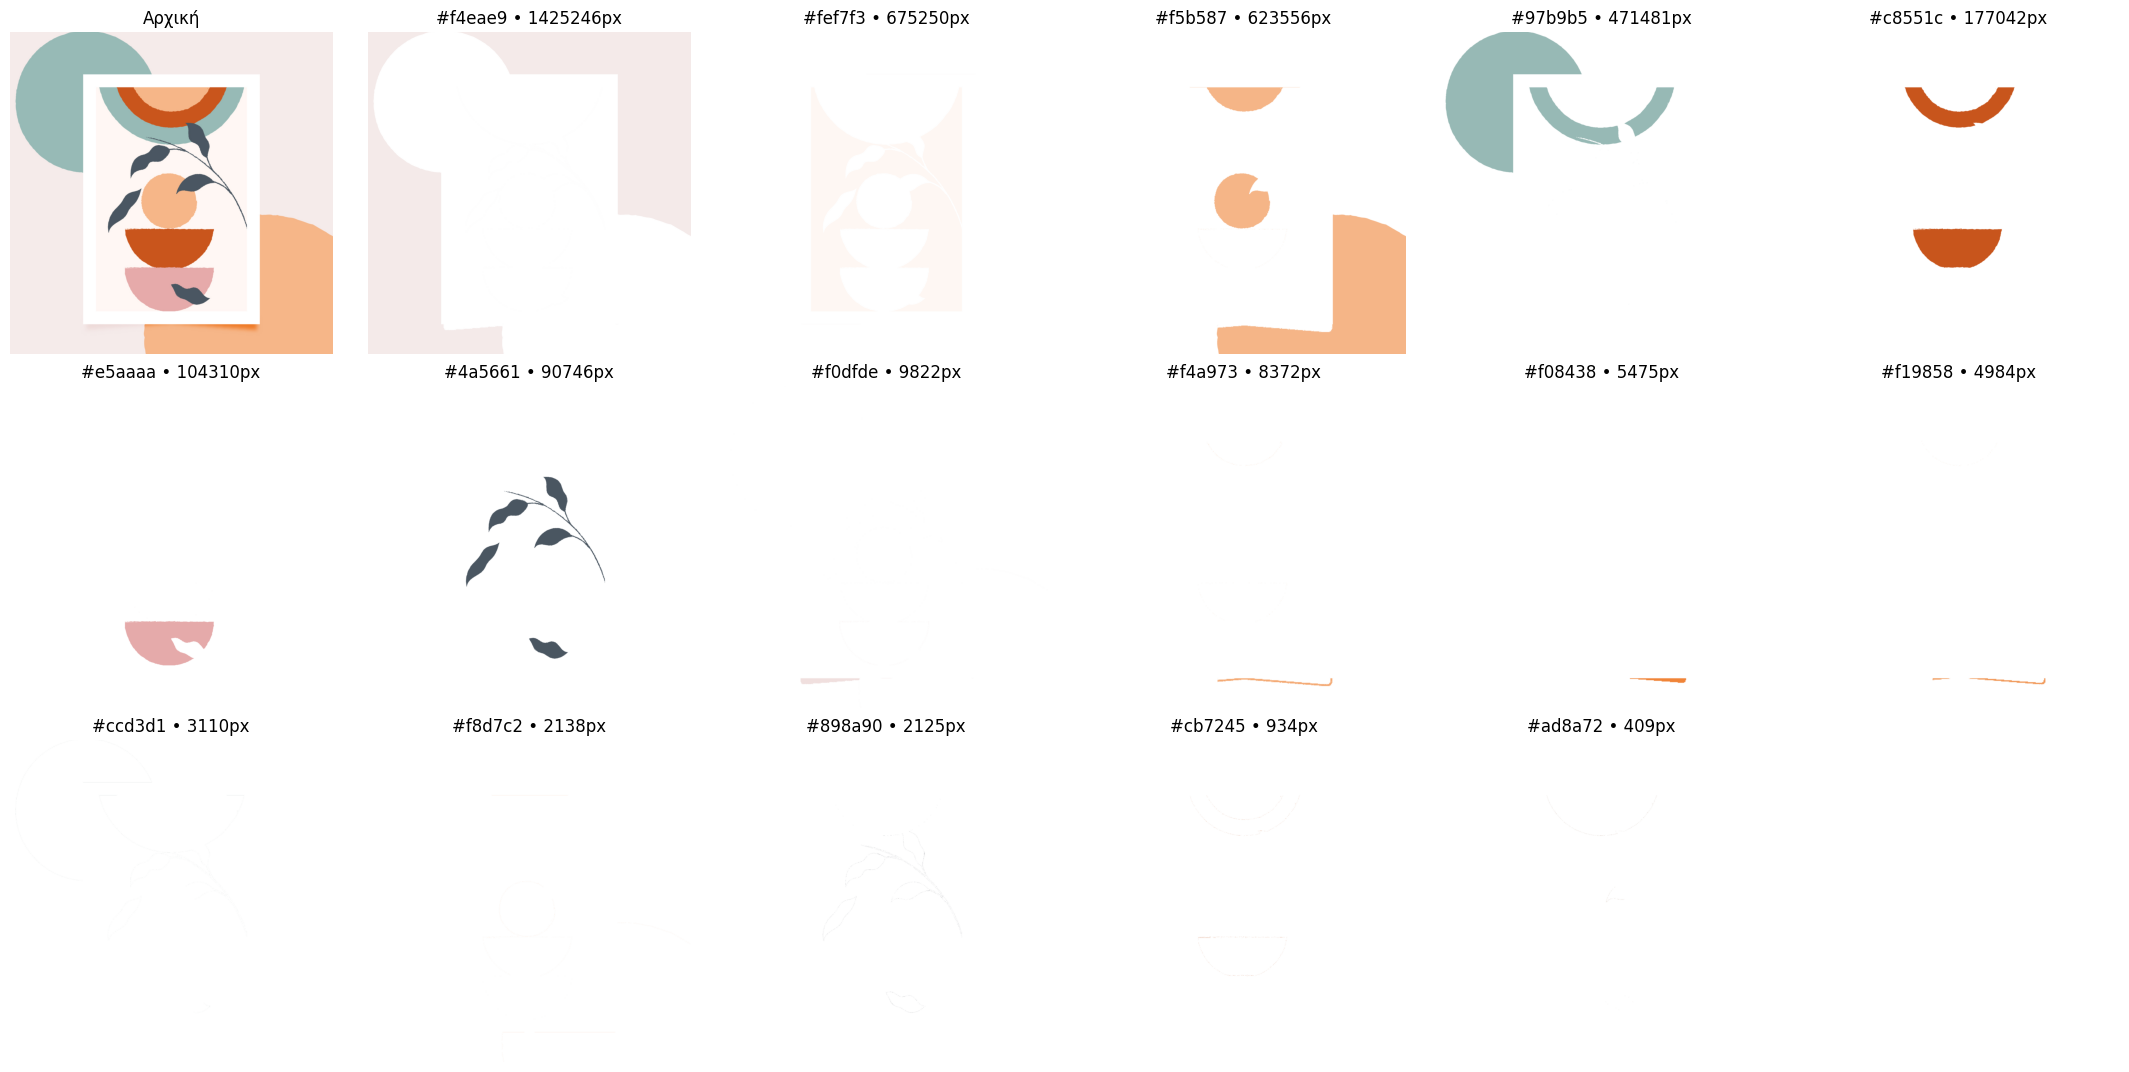

Layers: 16 (K=16 για τα flat χρώματα + dark layer)
HEX: ['#f4eae9', '#fef7f3', '#f5b587', '#97b9b5', '#c8551c', '#e5aaaa', '#4a5661', '#f0dfde', '#f4a973', '#f08438', '#f19858', '#ccd3d1', '#f8d7c2', '#898a90', '#cb7245', '#ad8a72']
Αποθήκευση: στον φάκελο panels_out


39385

In [ ]:
# === Flat colors via K-Means (CIELAB) + extra "dark features" layer (eyebrows, mole) ===
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
import io, os, sys, gc

# προσθέτουμε scikit-image για μορφολογικά φίλτρα
try:
    from skimage.morphology import disk, opening
    from skimage.morphology import remove_small_objects
except Exception:
    %pip -q install scikit-image
    from skimage.morphology import disk, opening
    from skimage.morphology import remove_small_objects

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------------- ΡΥΘΜΙΣΕΙΣ ----------------
K_FIXED = None          # π.χ. 12 για σταθερά clusters, ή None για αυτόματο
K_MIN, K_MAX = 2, 20    # εύρος για αυτόματο K όταν K_FIXED=None

WHITE_THR = 248         # κόψιμο σχεδόν-λευκού φόντου (RGB >= WHITE_THR)

# --- ΝΕΟ: χειρισμός σκοτεινών χαρακτηριστικών (φρύδια/ελίτσα) χωρίς περιγράμματα ---
EXTRA_DARK_LAYER = True     # βγάλε extra εικόνα με σκούρα features
DARK_V = 0.25               # HSV value <=  => υποψήφια «σκούρα»
DARK_S = 0.55               # HSV saturation <=
DARK_OPEN_RADIUS = 1        # opening για να σβήσουν λεπτά περιγράμματα (1 ή 2 είναι συνήθως αρκετό)
MIN_DARK_PIX = 8            # μικρό όριο για να κρατηθεί και η ελιά

# --- Λοιπά ---
BLACK_V   = 0.18        # κρατάμε για αναφορά, πλέον ΔΕΝ κόβουμε εξ αρχής τα μαύρα
BLACK_S   = 0.45
MIN_PIX   = 300         # ελάχιστο μέγεθος cluster (κόβει σκουπιδάκια για τα κανονικά layers)

SAVE_PANELS = True      # αποθήκευση panels σε αρχεία PNG
OUT_DIR = "panels_out"  # φάκελος εξόδου

# --- Επιτάχυνση ---
AUTO_SAMPLE_MAX = 20000  # δείγμα για επιλογή K (silhouette)
FIT_SAMPLE_MAX  = 50000  # δείγμα για fit KMeans (πολύ πιο γρήγορα)
KMEANS_MAX_ITER = 100    # αρκετό για σύγκλιση
KMEANS_N_INIT   = 10
KMEANS_ALGO     = "elkan"  # ταχύτερος για Euclidean

# ---------------- Helpers ----------------
def rgb_to_hsv(imgf):
    r,g,b = imgf[...,0], imgf[...,1], imgf[...,2]
    cmax = np.max(imgf, axis=-1); cmin = np.min(imgf, axis=-1)
    d = cmax - cmin + 1e-12
    h = np.zeros_like(cmax)
    m = d>0
    rm=(cmax==r)&m; gm=(cmax==g)&m; bm=(cmax==b)&m
    h[rm] = ((g-b)[rm]/d[rm])%6.0
    h[gm] = ((b-r)[gm]/d[gm])+2.0
    h[bm] = ((r-g)[bm]/d[bm])+4.0
    h = h/6.0
    s = np.zeros_like(cmax); s[cmax>0] = d[cmax>0]/cmax[cmax>0]
    v = cmax
    return h,s,v

def srgb_to_linear(c):
    c = c/255.0; a = 0.055
    return np.where(c<=0.04045, c/12.92, ((c+a)/(1+a))**2.4)

def linear_to_srgb(c):
    a = 0.055
    return np.where(c<=0.0031308, 12.92*c, (1+a)*np.power(c, 1/2.4)-a)

def rgb2lab(rgb):  # rgb: (N,3) uint8
    rgb = rgb.astype(np.float32)
    r,g,b = srgb_to_linear(rgb[:,0]), srgb_to_linear(rgb[:,1]), srgb_to_linear(rgb[:,2])
    X = r*0.4124564 + g*0.3575761 + b*0.1804375
    Y = r*0.2126729 + g*0.7151522 + b*0.0721750
    Z = r*0.0193339 + g*0.1191920 + b*0.9503041
    Xn,Yn,Zn = 0.95047,1.0,1.08883
    x,y,z = X/Xn, Y/Yn, Z/Zn
    eps,kappa = 0.008856,903.3
    fx = np.where(x>eps, np.cbrt(x), (kappa*x+16)/116)
    fy = np.where(y>eps, np.cbrt(y), (kappa*y+16)/116)
    fz = np.where(z>eps, np.cbrt(z), (kappa*z+16)/116)
    L = 116*fy-16; a = 500*(fx-fy); b = 200*(fy-fz)
    return np.stack([L,a,b], axis=1).astype(np.float32)

def lab2rgb(lab):  # lab: (...,3) float32/float64
    L,a,b = lab[...,0], lab[...,1], lab[...,2]
    fy = (L + 16.0) / 116.0
    fx = fy + a/500.0
    fz = fy - b/200.0
    eps, kappa = 0.008856, 903.3

    x3 = fx**3; z3 = fz**3
    xr = np.where(x3>eps, x3, (116*fx-16)/kappa)
    yr = np.where(L>kappa*eps, ((L+16)/116.0)**3, L/kappa)
    zr = np.where(z3>eps, z3, (116*fz-16)/kappa)

    Xn,Yn,Zn = 0.95047,1.0,1.08883
    X = xr*Xn; Y = yr*Yn; Z = zr*Zn

    r =  3.2404542*X -1.5371385*Y -0.4985314*Z
    g = -0.9692660*X +1.8760108*Y +0.0415560*Z
    b =  0.0556434*X -0.2040259*Y +1.0572252*Z

    r = linear_to_srgb(np.clip(r, 0.0, 1.0))
    g = linear_to_srgb(np.clip(g, 0.0, 1.0))
    b = linear_to_srgb(np.clip(b, 0.0, 1.0))
    rgb = np.stack([r,g,b], axis=-1)*255.0
    return np.clip(rgb, 0, 255).astype(np.uint8)

def to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

# ---------------- Upload ----------------
print("Ανέβασε PNG/JPG")
up = files.upload()
fname = next(iter(up))
im = Image.open(io.BytesIO(up[fname])).convert("RGBA")

# Composite σε λευκό αν υπάρχει άλφα
bg = Image.new("RGBA", im.size, (255,255,255,255))
im = Image.alpha_composite(bg, im).convert("RGB")
img = np.array(im)
imgf = img.astype(np.float32)/255.0

# ---------------- Μάσκες λευκού & σκοτεινών χαρακτηριστικών ----------------
# 1) Κόψε το σχεδόν-λευκό φόντο
white = (img[...,0]>=WHITE_THR) & (img[...,1]>=WHITE_THR) & (img[...,2]>=WHITE_THR)

# 2) ΝΕΟ: εντοπισμός dark features (φρύδια/ελιά/μαστίγια κ.λπ.) σε HSV,
#    και "άνοιγμα" για να φύγουν λεπτά περιγράμματα/γραμμές
h,s,v = rgb_to_hsv(imgf)
dark_candidates = (v <= DARK_V) & (s <= DARK_S)
dark_clean = opening(dark_candidates, disk(DARK_OPEN_RADIUS))
dark_clean = remove_small_objects(dark_clean, min_size=MIN_DARK_PIX, connectivity=2)

# Η K-means είσοδος: όλα εκτός από λευκό και (προαιρετικά) τα dark features
keep_mask = ~white
if EXTRA_DARK_LAYER:
    keep_mask &= ~dark_clean

flat_keep = keep_mask.reshape(-1)
coords = np.where(flat_keep)[0]
if coords.size == 0:
    raise ValueError("Δεν υπάρχουν pixels για clustering. Ρύθμισε WHITE_THR ή έλεγξε το input.")

rgb_keep = img.reshape(-1,3)[coords]
lab_keep = rgb2lab(rgb_keep)  # float32

# ---------------- Εκτίμηση K (γρήγορα, σε δείγμα) ----------------
if K_FIXED is None:
    n = lab_keep.shape[0]
    m = min(AUTO_SAMPLE_MAX, n)
    idx = np.random.choice(n, m, replace=False)
    Xs = lab_keep[idx]
    best_k, best_sc = K_MIN, -1.0
    if np.unique(Xs, axis=0).shape[0] < 2:
        K = 2
    else:
        upper = min(K_MAX, max(K_MIN+1, Xs.shape[0]-1))
        for k in range(K_MIN, upper + 1):
            km = KMeans(n_clusters=k, n_init=KMEANS_N_INIT, max_iter=KMEANS_MAX_ITER,
                        random_state=42, algorithm=KMEANS_ALGO).fit(Xs)
            labels = km.labels_
            if len(np.unique(labels)) < 2:
                continue
            sc = silhouette_score(Xs, labels)
            if sc > best_sc:
                best_k, best_sc = k, sc
        K = max(best_k, 2)
else:
    K = int(K_FIXED)

print(f"[INFO] Επιλεγμένο K = {K}")

# ---------------- K-Means: fit σε ΔΕΙΓΜΑ, predict σε ΟΛΑ (πολύ πιο γρήγορο) ----------------
n_all = lab_keep.shape[0]
m_fit = min(FIT_SAMPLE_MAX, n_all)
idx_fit = np.random.choice(n_all, m_fit, replace=False)
X_fit = lab_keep[idx_fit]

print(f"[INFO] Fit KMeans σε δείγμα {m_fit} από {n_all} pixels...")
km = KMeans(n_clusters=K, n_init=KMEANS_N_INIT, max_iter=KMEANS_MAX_ITER,
            random_state=42, algorithm=KMEANS_ALGO).fit(X_fit)

lab_centers = km.cluster_centers_.astype(np.float32)
print("[INFO] Predict labels σε όλα τα pixels...")
labels_keep = km.predict(lab_keep)

# ---------------- Labels για όλη την εικόνα ----------------
h_img, w_img = img.shape[:2]
labels_full = np.full(h_img * w_img, -1, dtype=np.int32)
labels_full[coords] = labels_keep
labels_full = labels_full.reshape(h_img, w_img)

# ---------------- Φίλτρο ελάχιστου εμβαδού + layers (flat fill από centroid) ----------------
layers, meta = [], []
white_bg = np.full_like(img, 255, dtype=np.uint8)  # λευκό φόντο

# RGB centroids
centroid_rgb = lab2rgb(lab_centers[None, :, :])[0]  # (K,3) uint8

for g in range(K):
    mask = (labels_full == g)
    area = int(mask.sum())
    if area < MIN_PIX:
        continue
    rep_rgb = centroid_rgb[g]
    out = white_bg.copy()
    out[mask] = rep_rgb
    layers.append(out)
    meta.append((area, to_hex(rep_rgb)))

# ---------------- ΝΕΟ: πρόσθεσε layer για dark features (φρύδια/ελιά) ----------------
if EXTRA_DARK_LAYER:
    dark_area = int(dark_clean.sum())
    if dark_area >= MIN_DARK_PIX:
        dark_layer = white_bg.copy()
        dark_layer[dark_clean] = img[dark_clean]  # κράτα τα αυθεντικά σκούρα χρώματα
        # Για τίτλο, βάλε το median χρώμα του layer
        drgb = np.median(img[dark_clean].reshape(-1,3), axis=0).astype(np.uint8)
        layers.append(dark_layer)
        meta.append((dark_area, to_hex(drgb)))

# Αν δεν έμεινε τίποτα…
if not layers:
    raise ValueError("Όλα τα clusters κόπηκαν λόγω MIN_PIX. Μείωσε MIN_PIX ή χαλάρωσε τα thresholds.")

# Ταξινόμηση κατά μέγεθος (μεγάλα πρώτα)
order = np.argsort([-a for a,_ in meta])
layers = [layers[i] for i in order]
meta   = [meta[i]   for i in order]

# ---------------- Αποθήκευση panels (προαιρετικά) ----------------
if SAVE_PANELS:
    os.makedirs(OUT_DIR, exist_ok=True)
    for i, layer in enumerate(layers, start=1):
        Image.fromarray(layer).save(os.path.join(OUT_DIR, f"panel_{i:02d}.png"))

# ---------------- Εμφάνιση inline ----------------
cols = min(6, len(layers)+1)
rows = int(np.ceil((len(layers)+1) / cols))
plt.figure(figsize=(3.6*cols, 3.6*rows))
plt.subplot(rows, cols, 1); plt.imshow(img); plt.title("Αρχική"); plt.axis("off")
for i, (layer,(area,hx)) in enumerate(zip(layers, meta), start=2):
    plt.subplot(rows, cols, i); plt.imshow(layer); plt.title(f"{hx} • {area}px"); plt.axis("off")
plt.tight_layout(); plt.show()

print(f"Layers: {len(layers)} (K={K} για τα flat χρώματα + {'dark layer' if EXTRA_DARK_LAYER else 'χωρίς dark layer'})")
print("HEX:", [hx for _,hx in meta])
print(f"Αποθήκευση: {('στον φάκελο '+OUT_DIR) if SAVE_PANELS else 'καμία αποθήκευση (SAVE_PANELS=False)'}")

# Καθάρισμα μνήμης
del km, lab_keep, rgb_keep
gc.collect()